# HYSPLIT vs STILT Outputs:

Simulation Notes: 

HYSPLIT Data: 

    - Puff Simulations utilizing 100 puffs

In [3]:
#Libraries:
import geopandas as gpd
import matplotlib.pyplot as plt

import contextily as ctx

## Functions

In [4]:
def file_to_geoframe(path):
    """A function to take a shapefile with concentration element and convert to a geodataframe
    """
    gdf = gpd.read_file(path)
    gdf = gpd.GeoDataFrame(gdf,crs=gdf.crs)

    try:
        gdf['CONC']=gdf['CONC'].astype(float)
    except:
        print('No concentration data')

    gdf = gdf.to_crs('epsg:3857')
    return gdf

def tri_concatenate(folder,utah_shape,grid_shape):
    '''Takes multiple hysplit plume shapefiles and harmonizes over location and time. Keeps all chemicals seperate, only sums those with same chemid. 
        
        Input:
        ----------
        HYSPLIT_folder_path: path to the TRI output files. Need to have and HO_ prior to the data entries
        utah_shape: A shapefile of the border of utah. EPSG 3857
        grid_shape: a fishnet grid of utah (1kmx1km for Hanson purposes)

        Returns:
        utah_grid_df: a dataframe consisting of 1km x 1km squares of Utah which are filled with harmonized chemical data
    '''
    #Grab the data entries
    #folder_list=sorted(glob.glob(HYSPLIT_folder_path+'/HO_*'))

    #Concatenate the output data to a grid
    counter = 0
    utah_grid_list = []
    for path in sorted(glob.glob(folder +'/hour*',recursive=True)):

        #Extract information from model file name
        #TODO sub with REGEX to make this more robust
        temp = path.split('HO')[1].split('_')
        FRS_ID = temp[1]
        CAS = temp[2]
        hour_after = datetime.timedelta(hours = int(temp[-1]))
        ymdh= temp[6] +'_'+ temp[7] +'_'+ temp[8] +'_'+temp[9].split('/')[0]
        ymdh=datetime.datetime.strptime(ymdh,'%y_%m_%d_%H')
        ymdh =ymdh + hour_after

        #Load into a geodataframe
        data = file_to_geoframe(path)
        data['CAS'] = CAS
        data['FRS_ID']=FRS_ID
        data = data.to_crs('epsg:3857')
    
        #Verify there is concentration data 
        if 'CONC' not in data.columns:
            print('Shapefile has no concentration column')
            continue 

        #Check to make sure there is data within the Utah Boundaries
        state_boundary = utah_shape[utah_shape['STATE']=='Utah']
        test_join = (gpd.sjoin(state_boundary,data, how='inner',op='intersects'))
        if test_join.empty:
            print('No part of this shape is within Utah: ' + path)
            continue

        #Merge to grid
        tmp = gpd.sjoin(grid_shape,data, how='left',op='intersects')
        #Where shapes overlap, taking the max
        tmp=tmp.sort_values('CONC', ascending=False).drop_duplicates('USNG').sort_index()

        #Remove the log transformation in order to perform spatial sum
        tmp['non_log_CONC'] = np.power(10,tmp['CONC'])

        #Save Entries to a temporary dictionary
        utah_grid_list.append(tmp)

    # Concatenate all the grids together, then group by to create a proper dataframe 
    #OID_ is the tile number
    utah_grid_df = pd.concat(utah_grid_list)
    utah_grid_df = utah_grid_df.groupby(by=['DATE','TIME','CAS','USNG','index']).agg({'non_log_CONC':'sum', 
                                                                                'FRS_ID':'first',
                                                                                'geometry':'first'})    

    utah_grid_df = utah_grid_df.reset_index()
    utah_grid_df['log_CONC'] = np.log10(utah_grid_df['non_log_CONC'])

    return utah_grid_df

def geoplot(geo_df, ax,col_of_interest,point_data=False):

    """A plotting function for geographic areas
    
    ===
    Inputs:
    geo_df: A geodataframe with geometry column for plotting. For added background map, please ensure EPSG is set to 3857
    ax: The axis for plotting
    title: the title of the plot
    
    Returns:
    none
    ===
    """    
    #Plotting for points
    if point_data == True: 
        geo_df.plot(cmap='YlOrRd',
                    ax=ax,
                    column=col_of_interest,
                    markersize=20)
    
    else: #Assume shapefiles are being plotted
        geo_df.plot(cmap='YlOrRd',
            ax=ax,
            column=col_of_interest)
    #Plot a background map if the EPSG is configured correctly
    if geo_df.crs == 3857:
        ctx.add_basemap(ax)
    
def hysplit_grid_post_processing(tri_grid):
    '''Takes multiple hysplit plume shapefiles and harmonizes over location and time. Keeps all chemicals seperate, only sums those with same chemid. 

    Input:
    ----------
    tri_grid - an output coming from tri_concat (HYSPLIT output to grid (nationalgrid from esri))

    Returns:
    sim_avg: a geodataframe of the average non-log_conc per the simulation run (48 hr with current setup) transformed to points for comparison
    '''  
    tri_grid = tri_grid.groupby(['index']).agg({'geometry':'first','non_log_CO':'sum'})
    sim_avg = gpd.GeoDataFrame(tri_grid, geometry=tri_grid['geometry'])
    sim_avg.crs = 'epsg:3857' #taken from TRI concat which pushes to epsg 3857
    sim_avg['geometry'] = sim_avg['geometry'].centroid
    return sim_avg

# Load the Data

Need to load the HYSPLIT data ouputs --> based upon puff simulation converted to grid. 

In [ ]:
#Load External Data: Need State Boundaries and an empty grid file: 
#State Data
state =fiona.open('/home/boogie2/Data_Science/Purp_Air_Analysis/Utah.gdb')
state_gdf = gpd.GeoDataFrame.from_features([feature for feature in state], crs=state.crs)
columns = list(state.meta["schema"]["properties"]) + ["geometry"]
state_gdf = state_gdf[columns]
state_gdf = state_gdf.to_crs('EPSG:3857')

#Grid Data 
nat_grid=gpd.read_file("/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/NationalGrid.gdb")
nat_grid = nat_grid.reset_index()

#Intialized with NAD83
nat_grid.crs = 'epsg:26912'
nat_grid = nat_grid.to_crs('epsg:3857')

In [ ]:
#Load in Conjugate Data from HYSPLIT
#So I need to create a 24 hour average grid cell for each 
#Questioning if any of these are wrong. Attempting to compare all the releases in a single figure
hysplit_11243_4166=tri_concatenate('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/data/HO_110032607329_123911_41.66_-112.43_0.00_90_01_01_00',state_gdf,nat_grid
)
hysplit_11200_4173=tri_concatenate('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/data/HO_110055233251_7664939_40.73_-112.0_0.00_90_01_01_00',state_gdf,nat_grid
)
hysplit_11189_4071=tri_concatenate('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/data/HO_110064119555_7664939_40.71_-111.89_0.00_90_01_01_00',state_gdf,nat_grid
)
hysplit_11202_4109=tri_concatenate('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/data/HO_110069446790_123911_41.09_-112.02_0.00_90_01_01_00',state_gdf,nat_grid
)

#HYSPLIT: Average the grid per the simulation run time --> 48 hours
hysplit_11243_4166_sim_avg = hysplit_grid_post_processing(hysplit_11243_4166)
hysplit_11200_4173_sim_avg = hysplit_grid_post_processing(hysplit_11200_4173)
hysplit_11189_4071_sim_avg = hysplit_grid_post_processing(hysplit_11189_4071)
hysplit_11202_4109_sim_avg = hysplit_grid_post_processing(hysplit_11202_4109)

#saving
hysplit_11243_4166_sim_avg.to_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11243_4166_sim_avg/shapey.shp')
hysplit_11200_4173_sim_avg.to_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11200_4173_sim_avg/shapey.shp')
hysplit_11189_4071_sim_avg.to_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11189_4071_sim_avg/shapey.shp')
hysplit_11202_4109_sim_avg.to_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11202_4109_sim_avg/shapey.shp')


In [7]:
#Load the simulations
hysplit_11243_4166_sim_avg = gpd.read_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11243_4166_sim_avg')
hysplit_11200_4173_sim_avg = gpd.read_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11200_4173_sim_avg')
hysplit_11189_4071_sim_avg = gpd.read_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11189_4071_sim_avg')
hysplit_11202_4109_sim_avg = gpd.read_file('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/HYSPLIT_STILT_COMPAR/hysplit_11202_4109_sim_avg')

#Get the data ready for plotting
hysplit_11243_4166_sim_avg = hysplit_grid_post_processing(hysplit_11243_4166_sim_avg)
hysplit_11200_4173_sim_avg = hysplit_grid_post_processing(hysplit_11200_4173_sim_avg)
hysplit_11189_4071_sim_avg = hysplit_grid_post_processing(hysplit_11189_4071_sim_avg)
hysplit_11202_4109_sim_avg = hysplit_grid_post_processing(hysplit_11202_4109_sim_avg)

#Adjust the values for better visualization 
hysplit_11243_4166_sim_avg = hysplit_11243_4166_sim_avg[hysplit_11243_4166_sim_avg.non_log_CO > 0.01]
hysplit_11200_4173_sim_avg = hysplit_11200_4173_sim_avg[hysplit_11200_4173_sim_avg.non_log_CO > 0.01]
hysplit_11189_4071_sim_avg = hysplit_11189_4071_sim_avg[hysplit_11189_4071_sim_avg.non_log_CO > 1]
hysplit_11202_4109_sim_avg = hysplit_11202_4109_sim_avg[hysplit_11202_4109_sim_avg.non_log_CO > 10]

# Stilt Simulations

Create the simulation dataframe in an r script

`x <- data.frame("lati" = c(41.663,40.72557,40.70739,41.093219), "long" = c(-112.432,-112.00081,-111.89273,-112.028221), "zagl" = c(0.0,0.0,0.0,0.0))`

`saveRDS(x,file= 'data/processed/stilt_input/092120_hysplit_v_stilt.rds')`

Run Simulations with: 

`src/stilt_run/092120_hysplit_v_stilt.r`

In [ ]:
#R

In [7]:
#load_files:
stilt_11243_4166_sim_avg =  gpd.read_file('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/STILT/090420_base_run/199001010000_-112.432_41.663_0_foot/')
stilt_11200_4073_sim_avg =  gpd.read_file('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/STILT/090420_base_run/199001010000_-112.00081_40.72557_0_foot/')
stilt_11189_4071_sim_avg =  gpd.read_file('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/STILT/090420_base_run/199001010000_-111.89273_40.70739_0_foot/')
stilt_11203_4109_sim_avg =  gpd.read_file('/home/boogie2/Hanson_Lab/TRI_STILT/data/processed/STILT/090420_base_run/199001010000_-112.028221_41.093219_0_foot/')

### Visual Comparison: STILT vs HYSPLIT

TRI Original Release Locations: 

11243_4166    -112.432    41.663
<br>
11200_4073    -112.000    40.726
<br>
11189_4071    -111.89273  40.70739
<br>
11203_4109    -112.01698  41.09394     #This potentially has another option - 41.093219,-112.028221

**Conclusions**

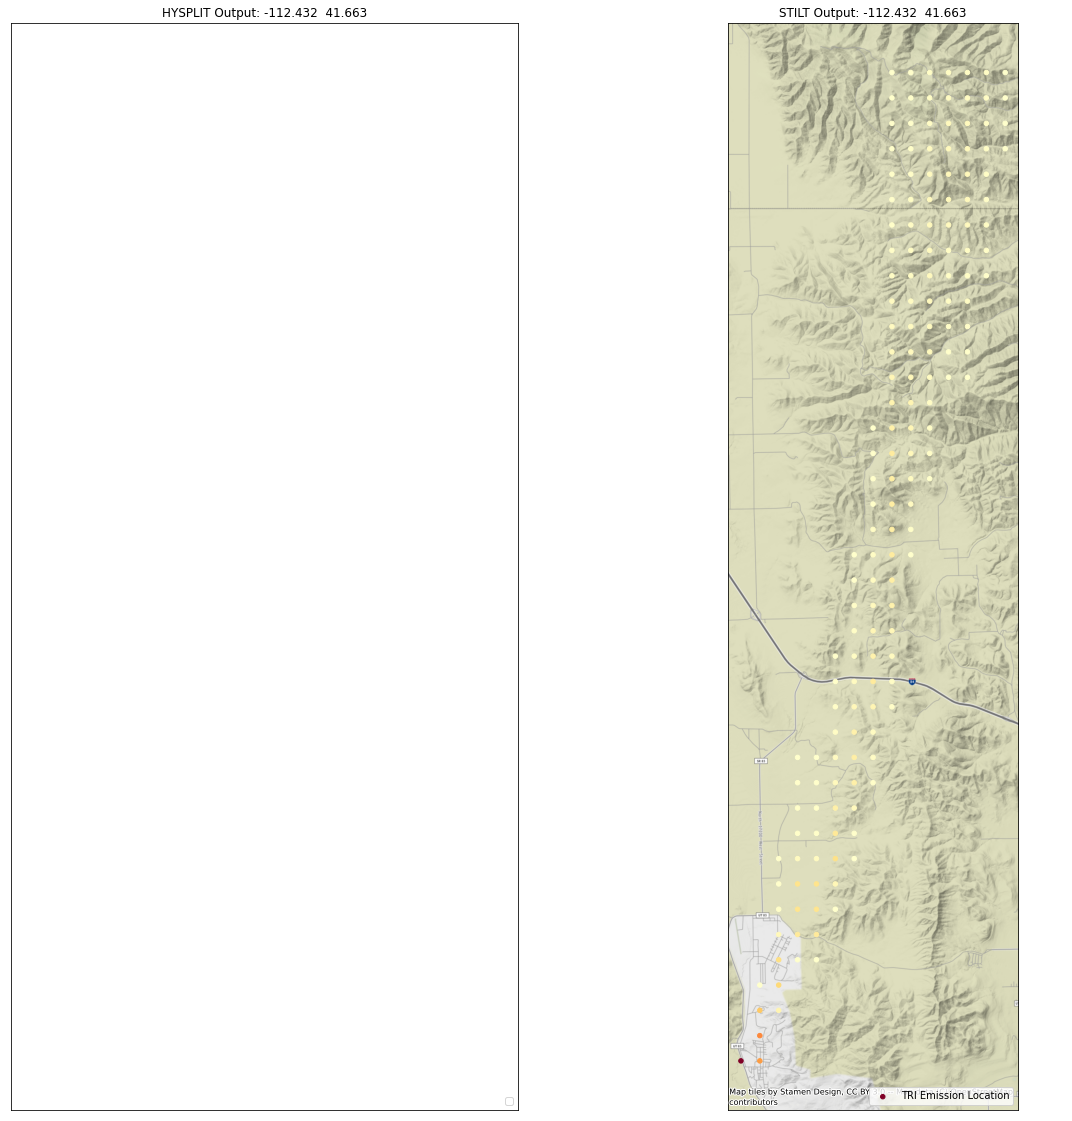

In [18]:
fig,ax = plt.subplots(1,2,figsize=(20,20))

for temp_ax in ax: 
    #Add the point source location
    original_TRI_release_locations_gdf.iloc[0:1].plot(color='r', markersize=40,alpha=0.5,ax=temp_ax)

    #Remove the axis 
    temp_ax.axes.get_xaxis().set_visible(False)
    temp_ax.axes.get_yaxis().set_visible(False)

geoplot(hysplit_11243_4166_sim_avg,ax[0],'non_log_CO', point_data = True)
geoplot(stilt_11243_4166_sim_avg,ax[1],'foot', point_data=True)

#Adjust the legends
ax[0].set_title('HYSPLIT Output: -112.432  41.663')
ax[0].legend(['TRI Emission Location'],loc='lower right')

ax[1].set_title('STILT Output: -112.432  41.663')
ax[1].legend(['TRI Emission Location'],loc='lower right')

#plt.savefig('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/plots/hysplit_vs_stilt_-112.432_41.663.png')
plt.close()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,20))

for temp_ax in ax: 
    #Add the point source location
    original_TRI_release_locations_gdf.iloc[1:2].plot(color='r', markersize=40,alpha=0.5,ax=temp_ax)

    #Remove the axis 
    temp_ax.axes.get_xaxis().set_visible(False)
    temp_ax.axes.get_yaxis().set_visible(False)

geoplot(hysplit_11200_4173_sim_avg,ax[0],'non_log_CO', point_data = True)
geoplot(stilt_11200_4073_sim_avg,ax[1],'foot',point_data=True)

#Adjust the legends
ax[0].set_title('HYSPLIT Output: -112.000  41.726')
ax[0].legend(['TRI Emission Location'],loc='lower right')

ax[1].set_title('STILT Output: -112.000  41.726')
ax[1].legend(['TRI Emission Location'],loc='lower right')

#plt.savefig('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/plots/hysplit_vs_stilt_-112.000_41.726.png')
plt.close()


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,20))

for temp_ax in ax: 
    #Add the point source location
    original_TRI_release_locations_gdf.iloc[2:3].plot(color='r', markersize=40,alpha=0.5,ax=temp_ax)

    #Remove the axis 
    temp_ax.axes.get_xaxis().set_visible(False)
    temp_ax.axes.get_yaxis().set_visible(False)

geoplot(hysplit_11189_4071_sim_avg,ax[0],'non_log_CO', point_data = True)
geoplot(stilt_11189_4071_sim_avg,ax[1],'foot',point_data=True)

#Adjust the legends
ax[0].set_title('HYSPLIT Output: -111.89273  40.70739 ')
ax[0].legend(['TRI Emission Location'],loc='lower right')

ax[1].set_title('STILT Output: -111.89273  40.70739 ')
ax[1].legend(['TRI Emission Location'],loc='lower right')

#plt.savefig('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/plots/hysplit_vs_stilt_-111.89273_40.70739.png')
plt.close()

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(20,20))

for temp_ax in ax: 
    #Add the point source location
    original_TRI_release_locations_gdf.iloc[3:].plot(color='r', markersize=40,alpha=0.5,ax=temp_ax)

    #Remove the axis 
    temp_ax.axes.get_xaxis().set_visible(False)
    temp_ax.axes.get_yaxis().set_visible(False)

geoplot(hysplit_11202_4109_sim_avg,ax[0],'non_log_CO', point_data = True)
geoplot(stilt_11203_4109_sim_avg,ax[1],'foot',point_data=True)

#Adjust the legends
ax[0].set_title('HYSPLIT Output: -112.01698  41.09394')
ax[0].legend(['TRI Emission Location'],loc='lower right')

ax[1].set_title('STILT Output: -112.01698  41.09394')
ax[1].legend(['TRI Emission Location'],loc='lower right')

#plt.savefig('/home/boogie2/Hanson_Lab/Environmental_Exposome/TRI/STILT/plots/hysplit_vs_stilt_-112.01698_41.09394.png')
plt.close()